# Finagling padding

There's a lot of padding. Ew, stinky. Instead, let's see how latency changes relative to upload size (for each number of mules), and see if there is a point that gives reasonable latency and smaller padding. Ideally we should be able to see a kink in the latency line, or we can just pick a latency we want to hit and reduce upload size appropriately.

We can also toggle upload size in order to meet some desired average goodput. Realistically, upload size (and frequency) would probably be selected by considering a tradeoff between latency and goodput.

In [10]:
# Import libraries.
import csv
import numpy as np
import pandas as pd
from matplotlib import cm
from matplotlib import pyplot as plt

In [6]:
num_mules_list = [10 * i for i in range(1, 11)]
upload_size_list = [1000, 5000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000]
naive_latency_list = []
batch_latency_list = []
batch_overhead_list = []
goodput_list = []
schedule_file = 'prob_data/random_uploads/vary_mules/{}_mule_{}_upload_schedule.csv'
dummy_file = 'prob_data/random_uploads/vary_mules/{}_mule_{}_upload_dummy.csv'

In [7]:
for num_mules in num_mules_list:
    naive_latencies = []
    batch_latencies = []
    goodputs = []
    for upload_size in upload_size_list:
        # Grab average packet latencies.
        schedule_df = pd.read_csv(schedule_file.format(num_mules, upload_size), skiprows=3)
        naive_latencies.append((schedule_df['pickup_time'] - schedule_df['sample_time']).mean())
        batch_latencies.append((schedule_df['batch_time'] - schedule_df['sample_time']).mean())
        
        # Grab average throughput.
        batch_throughput = sum(schedule_df['batch_time'] < 3600)
        
        # Grab dummy packets and calculate throughput.
        with open(dummy_file.format(num_mules, upload_size), 'r') as f:
            reader = csv.DictReader(f)
            for row in reader:
                samples_per_batch = int(row['samples_per_batch'])
                break
        dummy_df = pd.read_csv(dummy_file.format(num_mules, upload_size), skiprows=2)
        padded_throughput = sum(dummy_df['batch_time'] < 3600) * samples_per_batch
        goodputs.append(batch_throughput / padded_throughput)
    batch_overhead = [batch_boi - naive_boi for batch_boi, naive_boi in zip(batch_latencies, naive_latencies)]
    
    naive_latency_list.append(naive_latencies)
    batch_latency_list.append(batch_latencies)
    batch_overhead_list.append(batch_overhead)
    goodput_list.append(goodputs)

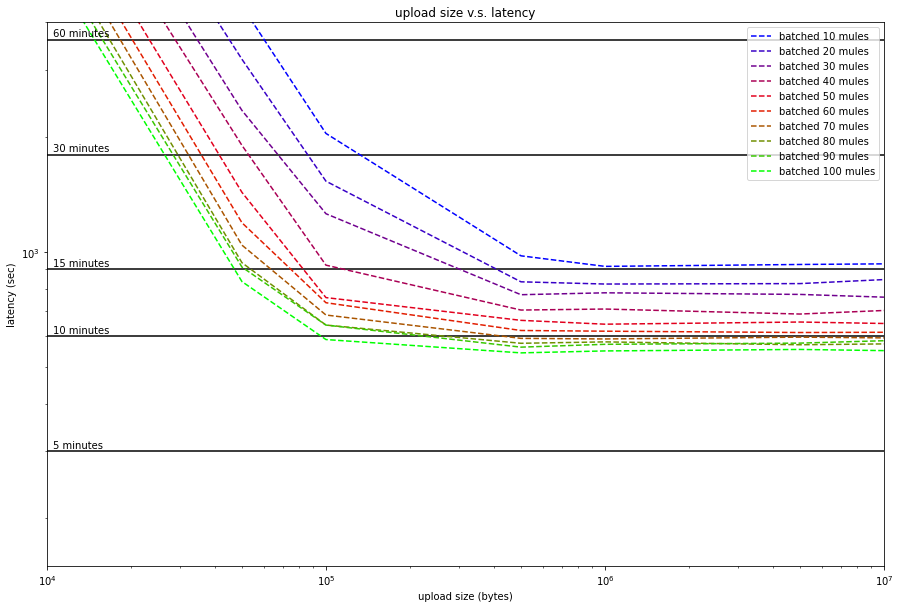

In [74]:
# Plot latencies over upload size
colors = cm.brg(np.linspace(0, 1, len(num_mules_list)))

plt.figure(figsize=(15,10))
for index, num_mules in enumerate(num_mules_list):
    #plt.plot(upload_size_list, naive_latency_list[index], color=colors[index], linestyle='-', label='naive {} mules'.format(num_mules))
    plt.plot(upload_size_list, batch_latency_list[index], color=colors[index], linestyle='--', label='batched {} mules'.format(num_mules))
    #plt.plot(upload_size_list, batch_overhead_list[index], color=colors[index], linestyle=':', label='overhead {} mules'.format(num_mules))

# Plot horizontal lines for timing
h_times = [3600, 1800, 900, 600, 300]
plt.hlines(h_times, 1e4, 1e7, color='black')
for h_time in h_times:
    plt.text(1.05e4, h_time*1.02, '{} minutes'.format(int(h_time/60)))

plt.legend()
plt.xlabel('upload size (bytes)')
plt.xscale('log')
plt.xlim(1e4, 1e7)
plt.ylabel('latency (sec)')
plt.yscale('log')
plt.ylim(150, 4000)
plt.title('upload size v.s. latency')

plt.show()

Ok, there's a lot of trimming happening, but I think this is the general idea of what we want in the end.

Now let's get a similar graph for goodput.

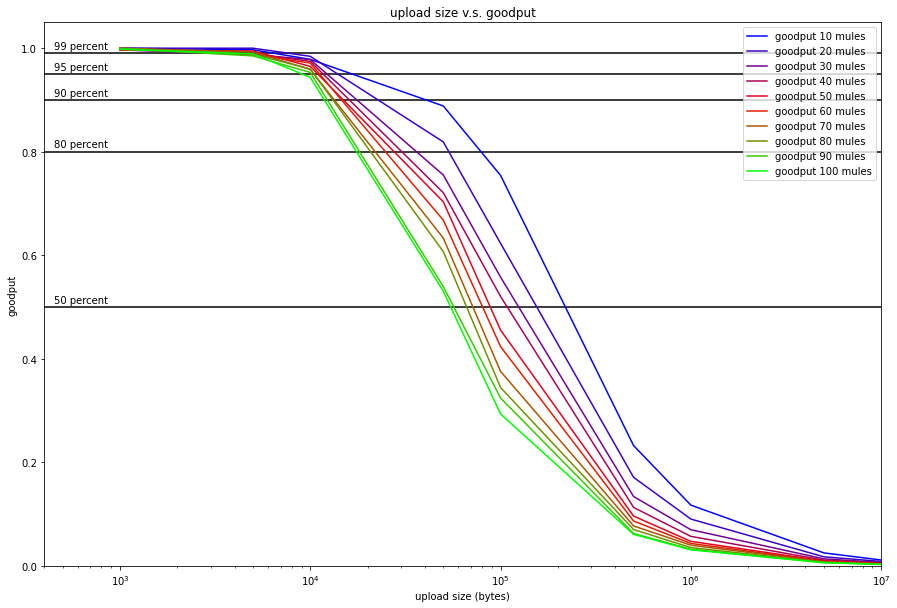

In [73]:
# Plot goodput over upload size
colors = cm.brg(np.linspace(0, 1, len(num_mules_list)))

plt.figure(figsize=(15,10))
for index, num_mules in enumerate(num_mules_list):
    plt.plot(upload_size_list, goodput_list[index], color=colors[index], linestyle='-', label='goodput {} mules'.format(num_mules))

# Plot horizontal lines
h_times = [0.99, 0.95, 0.9, 0.8, 0.5]
plt.hlines(h_times, 4e2, 1e7, color='black')
for h_time in h_times:
    plt.text(4.5e2, h_time+0.008, '{} percent'.format(int(h_time * 100)))

plt.legend()
plt.xlabel('upload size (bytes)')
plt.xscale('log')
plt.xlim(4e2, 1e7)
plt.ylabel('goodput')
#plt.yscale('log')
plt.ylim(bottom=0)
plt.title('upload size v.s. goodput')

plt.show()